# Machine Learning Exercise #4 - Neural Networks

이 연습을 위해 우리는 손으로 쓴 숫자 데이터 세트를 다시 다루겠습니다. 이번에는 역전파(backpropagation)와 피드 포워드 신경망을 사용합니다. 우리는 역전파 알고리즘을 통해 신경망 비용 함수와 기울기 계산의 정규화되지 않은 것과 정규화 된 버전을 구현할 것입니다. 랜덤 가중치 초기화와 네트워크를 사용하여 예측을 수행하는 방법도 구현할 것입니다.

데이터는 연습 3에서 사용한 데이터 세트와 동일하므로, 다음과 같이 코드를 다시 사용하여 데이터를 로드합니다.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('data/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

나중에 이들을 필요로 할 것이므로(그리고 자주 사용하기도 합니다), 유용한 변수를 미리 만들어 보겠습니다.

In [97]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

### 자료 시각화

다음의 코드는 데이터를 2 차원 플롯으로 표시합니다. 이것은 이전 연습에서 사용한 것과 동일한 데이터 세트입니다. 5000 개의 학습 예제가 있으며 각 연습 예제는 20x20 픽셀 회색 음영 이미지입니다. 각 픽셀은 해당 위치에서 그레이 스케일 강도를 나타내는 부동 소수점 숫자로 표시됩니다. 20 x 20 픽셀 격자는 400 차원 벡터로 주어집니다. 이 훈련 예제는 우리의 데이터 행렬 $X$에서 하나의 행이 됩니다.이 행렬은 손으로 쓴 자릿수 이미지에 대한 모든 행이 훈련 예제 인 5000 x 400 행렬 $X$를 제공합니다.
$$ X = \begin{bmatrix}
        - (x^{(1)})^T -\\
        - (x^{(2)})^T - \\
        \vdots\\
        - (x^{(m)})^T -\\
         \end{bmatrix}
         $$

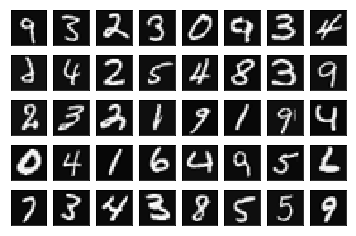

In [94]:
select = np.random.randint(5000, size=40)

fig, axs = plt.subplots(5,8,subplot_kw={'xticks': [], 'yticks': []})

for i in np.arange(5):
    for j in np.arange(8):
        one = np.matrix(data['X'])[select[i*8+j],:].reshape(20,20)
        axs[i][j].imshow(one.T, cmap='gray')
    
plt.show()

훈련 세트의 두 번째 파트는 트레이닝 세트의 레이블을 포함하는 5000차원 벡터입니다. 0 점 인덱스가없는 Octave / Matlab 인덱싱과 더 잘 호환되도록 숫자 0에 숫자 0을 매핑했습니다. 따라서 "0"자릿수는 "10"으로 표시되고 숫자 "1"- "9"는 자연 순서대로 "1"- "9"로 표시됩니다.

### 모델 표현

우리의 신경 네트워크는 아래의 그림 2에 나와 있습니다. 입력 층, 은닉 층 및 출력 층의 3개 층이 있습니다. 입력 값은 숫자 이미지의 픽셀 값입니다. 이미지의 크기가 20 × 20 이므로 400개의 입력 층 노드를 제공합니다 (항상 +1을 출력하는 추가 바이어스 노드 제외). 이전과 마찬가지로, 학습 데이터는 변수 $X$와 $y$에 로드됩니다.  

<img src="./data/fig2.png" width=400>

이미 우리가 훈련 한 네트워크 매개 변수 집합 ($\Theta^{(1)}, \Theta^{(2)}$)이 제공되었습니다. 이것들은 ex4weights.mat에 저장되어 있으며, Theta1과 Theta2로 읽혀집니다. 매개 변수에는 두 번째 층에 25 노드과 10 개의 출력 노드 (숫자 10개 클래스에 해당)이 있는 신경망에 맞는 크기를 갖습니다.

### 전방전파 및 비용 함수

이제 신경망에 대한 비용 함수와 그래디언트를 구현할 것입니다. 먼저 다음의 코드를 완성하여 비용을 반환하십시오.

신경망에 대한 비용 함수(정규화되지 않은)는 다음과 같습니다.

$$ J(\theta) = {1\over m} \sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)} \log(h_\theta(x^{(i)})_k) - (1 - y_k^{(i)}) \log(1-h_\theta(x^{(i)})_k)] $$

여기서 $h_\theta (x^{(i)})$는 그림 2와 같이 계산되고, K = 10은 가능한 레이블의 총 수입니다. $h (x^{(i)})_k = a_k^{(3)}$ 는 k 번째 출력 단위의 활성화(출력값)이다. 또한 원래의 레이블 (변수 y에서)은 1, 2, ..., 10 이었지만 신경망을 학습 할 목적으로 레이블을 0 또는 1 만 포함하 벡터로 다음처럼 표시된 원핫(one-hot) 벡터로 다시 코딩해야합니다. 
$$ y = \begin{bmatrix}
        1\\ 0\\ 0\\ \vdots\\ 0\\
         \end{bmatrix}
        ,
        \begin{bmatrix}
        0\\ 1\\ 0\\ \vdots\\ 0\\
         \end{bmatrix}
         , \cdots \text{ or },
         \begin{bmatrix}
        0\\ 0\\ 0\\ \vdots\\ 1\\
         \end{bmatrix}
         $$


우리는 y 레이블을 원핫(one-hot) 인코딩해야 합니다. one-hot 인코딩은 클래스 레이블 n (k 클래스들 중에서)을 길이가 k 인 벡터로 바꾸어줍니다. 여기서 인덱스 n은 hot(1)이고, 나머지는 0 입니다. Scikit-learn은 이것을 위해 사용할 수 있는 유틸리티가 내장되어 있습니다.



In [98]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [77]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

이 실습을 위해 구축 할 신경망에는 인스턴스 데이터 크기(400 + 바이어스 단위)의 입력 레이어와, 25개 단위(바이어스 단위를 포함하면 26)가 있는 히든 레이어와 함께, 클래스 레이블에 대한 우리의 one-hot 인코딩에 해당하는 10 단위의 출력 레이어가 있습니다. 네트워크 아키텍처에 대한 자세한 내용과 이미지는 "연습"폴더의 PDF를 참조하십시오.

우리가 구현해야 할 첫 번째 부분은 주어진 네트워크 매개 변수 집합에 대한 손실을 평가하는 비용 함수입니다. 다음은 비용을 계산하는 데 필요한 함수입니다.

In [78]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [79]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [102]:
def cost0(input_size, hidden_size, num_labels, X, y, theta1, theta2, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    return J

시그모이드 함수는 이전에소 사용했으므로 새 것이 아닙니다. forward-propagate 함수는 현재 주어진 매개변수로 각 학습 인스턴스에 대한 가설을 계산합니다. 출력 형태는 y에 대한 one-hot 인코딩과 동일해야 합니다. 우리는 이 사실을 빨리 테스트하여 예상대로 작동하고 있음을 확신 할 수 있습니다 (중간 단계도 나중에 유용하므로 반환됩니다).

코딩이 완료되면 Theta1과 Theta2에 대한 매개 변수 집합을 사용하여 cost 함수를 호출합니다. 비용은 약 0.287629입니다.

In [103]:
weights = loadmat('data/ex4weights.mat')
weights['Theta1'].shape, weights['Theta2'].shape

X = np.matrix(X)
y = np.matrix(y)
theta1 = np.matrix(weights['Theta1'])
theta2 = np.matrix(weights['Theta2'])

cost0(input_size, hidden_size, num_labels, X, y_onehot, theta1, theta2, reg_lambda)

0.2876291651613188

In [105]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
reg_lambda = 1

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [106]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

비용 함수는 가설 행렬 h를 계산 한 후 비용 방정식을 적용하여 y와 h 간의 총 오류를 계산합니다.

In [108]:
cost0(input_size, hidden_size, num_labels, X, y_onehot, theta1, theta2, reg_lambda)

7.047302989892117

다음 단계는 비용 함수에 정규화를 추가하는 것입니다. 운동 본문을 따라 가면서 마지막 방정식이 추악 해 보인다고 생각한다면,이 것은 정말보기 흉한 것처럼 보입니다. 실제로 보이는 것처럼 복잡하지는 않습니다. 사실, 정규화 용어는 단순히 우리가 이미 계산 한 비용에 추가 된 것입니다. 다음은 수정 된 비용 함수입니다.

In [109]:
def cost(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(reg_lambda) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

cost(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)

7.0526514270012814

다음은 backpropagation 알고리즘입니다. Backpropagation은 교육 데이터에서 네트워크의 오류를 줄이는 매개 변수 업데이트를 계산합니다. 우리가 먼저 필요로 하는 것은 우리가 이전에 생성한 시그모이드 함수의 그래디언트를 계산하는 함수입니다.

In [111]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [110]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(reg_lambda) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

(왜 우리가 이 모든 계산을 하는지 이해하는 것 외에) backprop 함수 계산의 가장 어려운 부분은 행렬 차원을 올바르게 얻는 것입니다. 그건 그렇고, A*B 와 np.multiply(A, B)를 혼동 할 때 혼란이 없다면 혼자가 아닙니다. 기본적으로 전자는 행렬 곱셈이고 후자는 요소 단위의 곱셈입니다 (A 또는 B는 스칼라 값이 아니라면 상관 없습니다). 

어쨌든 함수가 우리가 기대하는 바를 반환하는지 테스트 해 봅시다.

In [112]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)
J, grad.shape

(7.0526514270012814, (10285,))

그라데이션 계산에 정규화를 추가하여 백 드롭 기능을 수행 할 수있는 또 하나의 수정이 있습니다. 최종 정식 버전은 아래와 같습니다.

In [113]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(reg_lambda) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * reg_lambda) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * reg_lambda) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [114]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)
J, grad.shape

(7.0526514270012814, (10285,))

우리는 마침내 우리의 네트워크를 훈련시키고 예측을 위해 사용할 준비가되었습니다. 이것은 다중 클래스 로지스틱 회귀 분석을 사용한 이전의 운동과 거의 비슷합니다.

In [115]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, reg_lambda), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin


     fun: 0.34311481325806914
     jac: array([ 4.25532244e-04,  6.22608934e-07,  3.87209723e-07, ...,
       -3.22277126e-04, -2.34255242e-04, -2.23191625e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 22
  status: 3
 success: False
       x: array([-3.43328790e-01,  3.11304467e-03,  1.93604862e-03, ...,
        1.24642805e+00, -3.73446497e-01, -3.54875385e+00])

우리는 목적 함수가 완전히 수렴하지 않을 것이기 때문에 반복의 수를 제한합니다. 총 비용은 0.5 미만으로 떨어졌지만 알고리즘이 작동 중임을 나타내는 좋은 지표입니다. 찾은 매개 변수를 사용하고 네트워크를 통해 전달하여 일부 예측을 얻으십시오.

In [91]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])

마지막으로 정확성을 계산하여 숙련 된 네트워크가 얼마나 잘 작동하는지 확인할 수 있습니다.

In [93]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy =', accuracy * 100, '%')
#print 'accuracy = {0}%'.format(accuracy * 100)

accuracy = 0.995 %


그리고 우리는 끝났어! 우리는 백 프로 퍼 게이션 (backpropagation) 기능을 갖춘 초보 피드 포워드 (forward feed-forward) 신경망을 성공적으로 구현하여 손으로 쓴 자릿수의 이미지를 분류하는 데 사용했습니다. 다음 실습에서 우리는 또 다른 전력 감시 학습 알고리즘 인 지원 벡터 머신을 살펴볼 것입니다.